In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
import time
from sklearn import ensemble, metrics, preprocessing
from sklearn.experimental import enable_hist_gradient_boosting
import threadpoolctl
from scipy import stats
import joblib

In [2]:
## Self explanatory
save_plots = False
## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = True
## Toggle plot grid
show_grid = False
## Black and white?
black_and_white = True

## If true, load existing model (does not train a new one)
load_existing = False
## If true, save the trained model
save_model = True

## If true, evaluate and save feature importances
## Otherwise, load previous results
compute_importances = False

In [3]:
training_params = {
    'learning_rate' : 0.01,
    'max_leaf_nodes' : 100,
    'max_iter' : 2500
}

# number of threads used by a single job and number of jobs
# the total maximum number of CPU cores used is n_threads x n_jobs
n_threads = 8
n_jobs = 10

In [4]:
## Proton and pion momenta
## 'VF': use VF momenta
## 'DTF': use DTF momenta w/ JPsi m.c.
## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
## 'NO': don't use any momenta for Lambda daughter particles
daughter_momenta = 'DTF'

In [5]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/classifier-studies/'

plot_directory = (
    repo_dir + 'plots/'
    + 'train_and_evaluate_HBDT/'
)

state_directory = repo_dir + '20_HBDT/' + 'saved_states/'

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)
pathlib.Path(state_directory).mkdir(parents=True, exist_ok=True)

In [6]:
classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
)

classifier_dump_filename

'HBDT_DTF_0.01_100_2500'

# Load data

In [7]:
input_train = '~/classifier-studies/data/trainData.h5'
df_train = pd.read_hdf(input_train, 'LHCb_Train')
df_train

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,1499.261230,64090.687500,1449.125122,71109.312500,1339.061157,67585.578125,142.576462,16002.674805,222.223770,15295.935547,...,12.397956,1.006837,3.118125,4.247471,8394.141602,839.898499,0.0,0.0,1,5649.782715
1,6531.696777,43770.664062,7950.545410,53713.472656,7250.666016,48946.476562,1098.382568,7154.821289,1173.632935,7339.285645,...,72.018669,4.932845,9.285525,0.700478,316576.343750,28.328979,0.0,0.0,1,5346.287598
2,1195.592285,25513.001953,2846.242432,45061.835938,2590.605225,40850.550781,600.855042,6536.190430,531.966919,6502.588379,...,58.929020,38.498478,109.721619,0.822907,48769.886719,969.064880,0.0,0.0,1,5625.960449
3,8357.870117,48524.460938,13019.551758,77204.125000,10886.081055,65169.863281,954.039429,8363.340820,1251.309082,8721.902344,...,4.634126,2.500692,5.822659,0.760508,2613.000244,11152.960938,0.0,0.0,1,5480.049316
4,931.300659,24994.496094,1355.522217,32809.832031,1152.498901,30213.080078,812.275085,7415.243652,194.003128,7669.465332,...,2.344827,9.562636,28.231209,3.574740,1273.676514,22431.037109,0.0,1.0,1,5446.454102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5472644,1010.154358,43585.253906,834.157104,36020.722656,2062.077637,90746.234375,163.722885,7249.501465,162.814896,7284.698730,...,0.402552,1.787724,4.766886,29.171247,26563.222656,132.886627,0.0,1.0,0,7601.270508
5472645,788.994019,30219.402344,846.339722,29809.490234,950.482178,33396.257812,68.395859,2443.232910,77.663048,2415.952637,...,0.909791,1.954522,5.995909,62.136440,911979.750000,480.069275,0.0,0.0,0,6392.341797
5472646,514.532471,18133.210938,437.694672,18358.109375,1374.070068,58323.972656,275.153046,14757.525391,354.424286,14406.655273,...,0.603335,1.080816,2.631017,39.063274,739.135437,63.726597,0.0,3.0,0,6506.649414
5472647,1777.671997,77276.789062,1338.395874,72462.937500,7582.245117,364143.500000,78.957039,14143.750000,308.220764,13831.672852,...,0.171859,0.390803,1.136327,167.958542,1609.802612,171.852966,0.0,1.0,0,10292.375000


In [8]:
input_test = '~/classifier-studies/data/testData.h5'
df_test = pd.read_hdf(input_test, 'LHCb_Test')
df_test

,p_PT,p_PZ,DTF_FixJPsi_p_PT,DTF_FixJPsi_p_PZ,DTF_FixJPsiLambda_p_PT,DTF_FixJPsiLambda_p_PZ,pim_PT,pim_PZ,DTF_FixJPsi_pim_PT,DTF_FixJPsi_pim_PZ,...,L_VFASPF_CHI2_VDOF,Lb_VFASPF_CHI2_VDOF,L_BPVIPCHI2,Lb_BPVIPCHI2,L_BPVVDCHI2,Lb_BPVVDCHI2,DTF_FixJPsi_status,DTF_FixJPsiLambda_status,TYPE,DTF_FixJPsiLambda_Lb_M
0,2504.376465,27455.556641,2435.769775,27417.642578,2798.346191,3.118290e+04,416.471710,5826.424316,492.247925,5925.514648,...,0.116805,0.334404,0.975463,2.368801,8.063968e+03,1031.350098,0.0,0.0,1,5678.738770
1,3678.204834,28957.984375,8009.698242,63035.414062,4010.383301,3.170026e+04,511.451996,4495.157227,606.036377,5295.169922,...,129.013321,2.213622,3.035450,4.987368,1.139099e+06,132.812775,0.0,0.0,1,5152.405273
2,6151.153320,62528.351562,3390.550049,34433.933594,3191.249023,3.234711e+04,908.855103,8341.050781,954.033325,8586.155273,...,3.052457,1.626008,3.995702,3.794894,5.994128e+05,1733.996338,0.0,0.0,1,5610.329102
3,2215.048828,16164.611328,3509.922363,25586.275391,3299.109375,2.418392e+04,1217.576172,8981.918945,1129.961060,8099.306641,...,3.684547,6.168911,7.633062,1.222096,6.435177e+03,1848.107422,0.0,0.0,1,5655.911133
4,1299.116333,50831.921875,1585.503662,49852.496094,1661.818237,4.868604e+04,1164.087158,16436.048828,707.395447,15532.739258,...,3.191066,0.135195,0.518211,1.912595,1.069037e+03,329.424927,0.0,1.0,1,5623.918457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608068,411.917328,27935.982422,550.276550,27560.773438,557.743103,2.512412e+04,474.223877,7514.781738,279.620880,7413.750488,...,5.558394,0.530452,1.478899,4.734439,3.349014e+04,12.877452,0.0,0.0,0,6242.471680
608069,893.593811,28932.853516,328.149902,18283.841797,805.079895,6.084392e+04,479.921600,6497.299316,185.851608,7359.200684,...,3.561609,15.601482,45.002895,41.674271,1.093673e+04,69.625244,0.0,0.0,0,5971.600586
608070,1098.223389,48744.281250,901.191345,49259.585938,3195.478271,1.806445e+05,832.852722,64969.492188,1306.869385,92341.546875,...,0.171415,2.654114,3.192843,290.367554,6.753251e+02,30397.578125,0.0,0.0,0,9306.984375
608071,447.744995,23675.595703,3004.335205,159310.203125,8871.583984,1.020371e+06,224.838974,12676.066406,1363.665039,87908.609375,...,130.398666,21.177591,53.417313,484.353607,5.709859e+04,3404.125977,1.0,1.0,0,20059.242188


# Train the classifier
Or load a previously trained one. Whatever.

In [9]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [10]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

In [11]:
X_train = df_train.loc[:, features].to_numpy()
Y_train = df_train.loc[:, 'TYPE'].to_numpy()

X_test = df_test.loc[:, features].to_numpy()
Y_test = df_test.loc[:, 'TYPE'].to_numpy()

In [12]:
saved_state_file = state_directory + '/' + classifier_dump_filename + '.joblib'

In [13]:
if load_existing:
    HBDT = joblib.load(saved_state_file)
    print(f"HBDT imported.")
else:
    HBDT = ensemble.HistGradientBoostingClassifier(**training_params)
    
    tick = time.perf_counter()
    with threadpoolctl.threadpool_limits(n_threads, user_api="openmp"):
        HBDT.fit(X_train, Y_train)
    tock = time.perf_counter()
    print(f"HBDT trained in {(tock - tick)/60:0.4f} minutes.")
    
    if save_model:
        joblib.dump(HBDT, saved_state_file)
        print(f"HBDT saved.")

HBDT trained in 17.6123 minutes.
HBDT saved.


# Results evaluation

In [14]:
Y_train_predicted = HBDT.predict(X_train)
Y_test_predicted = HBDT.predict(X_test)

In [15]:
## predict_proba returns a NumberOfEvents * NumberOfClasses matrix
## The way we have defined it, the second column is the probability of class 1 (i.e. signal)
## Therefore we get that one
Y_train_proba_predicted = HBDT.predict_proba(X_train)[:,1]
Y_test_proba_predicted = HBDT.predict_proba(X_test)[:,1]

## Confusion matrices

In [16]:
def percentage_confusion_matrix(y_true, y_predicted):
    cmat = metrics.confusion_matrix(y_true, y_predicted)
    
    ## This normalizes to total number of events, signal and background
    #return cmat/np.sum(cmat)
    
    ## This normalizes by row: bkg to bkg, sig to sig
    return preprocessing.normalize(cmat,norm='l1')

In [17]:
def plot_conf_matrix(confusion_matrix, is_test: bool = False) -> None:
    
    if black_and_white:
        color_string = 'wkkw'
        cmap = 'gray_r'
    else:
        color_string = 'wkkw'
        
        if is_test:
            cmap = 'RdPu'
        else:
            cmap = 'bone_r'
    
    plt.imshow(confusion_matrix, cmap=cmap)
    ax = plt.gca()
    plt.colorbar(label='Fraction of events')
    plt.clim(0,1)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted bkg', 'Predicted signal'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual bkg', 'Actual signal'))
    plt.text(0, 0, "{:.2%}".format(confusion_matrix[0, 0]), ha='center', va='center', color=color_string[0])
    plt.text(0, 1, "{:.2%}".format(confusion_matrix[1, 0]), ha='center', va='center', color=color_string[1])
    plt.text(1, 0, "{:.2%}".format(confusion_matrix[0, 1]), ha='center', va='center', color=color_string[2])
    plt.text(1, 1, "{:.2%}".format(confusion_matrix[1, 1]), ha='center', va='center', color=color_string[3])
    
    if show_titles:
        if is_test:
            plt.title("Predicted vs. actual classes (test set)")
        else:
            plt.title("Predicted vs. actual classes (training set)")
    
    plt.show()

In [18]:
confusion_matrix_train = percentage_confusion_matrix(Y_train, Y_train_predicted)
confusion_matrix_test = percentage_confusion_matrix(Y_test, Y_test_predicted)

Just to be clear, normalization is on *actual* events.

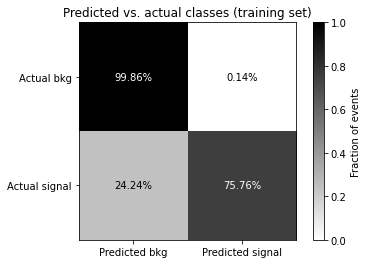

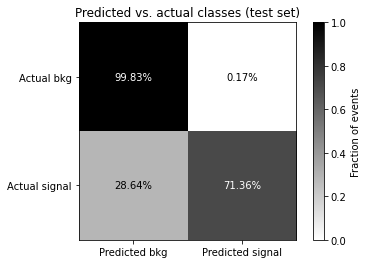

In [19]:
plot_conf_matrix(confusion_matrix_train, is_test=False)
plot_conf_matrix(confusion_matrix_test, is_test=True)

## Classification reports

In [20]:
print("TRAIN")
print(metrics.classification_report(Y_train, Y_train_predicted))
print(f'The average precision score on training data is: {metrics.average_precision_score(Y_train, Y_train_proba_predicted):.4f}')
print("------------------------------------------------------")
print("TEST")
print(metrics.classification_report(Y_test, Y_test_predicted))
print(f'The average precision score on test data is: {metrics.average_precision_score(Y_test, Y_test_proba_predicted):.4f}')

TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5400000
           1       0.88      0.76      0.81     72649

    accuracy                           1.00   5472649
   macro avg       0.94      0.88      0.91   5472649
weighted avg       1.00      1.00      1.00   5472649

The average precision score on training data is: 0.9134
------------------------------------------------------
TEST
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    600000
           1       0.85      0.71      0.77      8073

    accuracy                           0.99    608073
   macro avg       0.92      0.86      0.89    608073
weighted avg       0.99      0.99      0.99    608073

The average precision score on test data is: 0.8541


## ROC curve

In [21]:
train_false_positives, train_true_positives, train_roc_thresholds = metrics.roc_curve(Y_train, Y_train_proba_predicted)
train_auc = metrics.roc_auc_score(Y_train, Y_train_proba_predicted)

test_false_positives, test_true_positives, test_roc_thresholds = metrics.roc_curve(Y_test, Y_test_proba_predicted)
test_auc = metrics.roc_auc_score(Y_test, Y_test_proba_predicted)

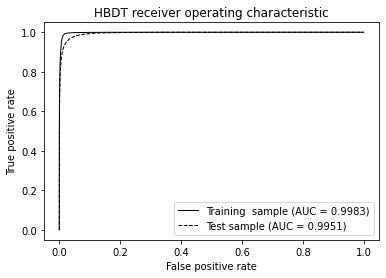

In [22]:
if not black_and_white:
    train_color = 'tab:red'
    test_color = 'tab:blue'
    linewidth=1.5
else:
    train_color = 'black'
    test_color='black'
    linewidth=1

plt.plot(train_false_positives,
         train_true_positives,
         label=f'Training  sample (AUC = {train_auc:.4f})',
         color=train_color,
         linestyle='-',
         linewidth=linewidth
)
plt.plot(test_false_positives,
         test_true_positives,
         label=f'Test sample (AUC = {test_auc:.4f})',
         color=test_color,
         linestyle='--',
         linewidth=linewidth
)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
if show_titles:
    plt.title("HBDT receiver operating characteristic")
plt.show()

## Precision-recall curve

In [23]:
train_precision, train_recalls, train_prc_thresholds = metrics.precision_recall_curve(Y_train, Y_train_proba_predicted)
test_precision, test_recalls, test_prc_thresholds = metrics.precision_recall_curve(Y_test, Y_test_proba_predicted)

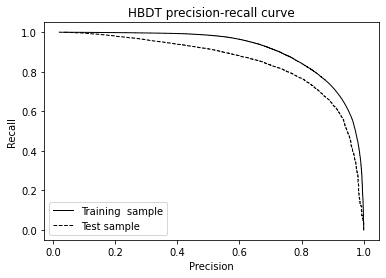

In [24]:
if not black_and_white:
    train_color = 'tab:red'
    test_color = 'tab:blue'
    linewidth=1.5
else:
    train_color = 'black'
    test_color='black'
    linewidth=1

plt.plot(train_precision,
         train_recalls,
         label=f'Training  sample',
         color=train_color,
         linestyle='-',
         linewidth=linewidth
)
plt.plot(test_precision,
         test_recalls,
         label=f'Test sample',
         color=test_color,
         linestyle='--',
         linewidth=linewidth
)

plt.xlabel('Precision')
plt.ylabel('Recall')

plt.legend()
if show_titles:
    plt.title("HBDT precision-recall curve")
plt.show()

## Response distribution

In [25]:
df_train_model_response = pd.DataFrame({'predicted' : Y_train_proba_predicted, 'class' : Y_train, 'dataset': 'train'})
df_test_model_response = pd.DataFrame({'predicted' : Y_test_proba_predicted, 'class' : Y_test, 'dataset': 'test'})

df_model_response = pd.concat([df_train_model_response, df_test_model_response], ignore_index=True)

del(df_train_model_response)
del(df_test_model_response)

In [26]:
is_training = df_model_response['dataset'] == 'train'
is_test = df_model_response['dataset'] == 'test'
is_signal = df_model_response['class'] == 1
is_bkg = df_model_response['class'] == 0

In [27]:
def plot_compared_responses(
    label_1,
    label_2,
    title,
    common_selection,
    selection_1,
    selection_2,
    cumulative = False,
    legend_frame = False
):
    
    if black_and_white:
        hist_1_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'black',
            'hatch': '--',
            'color': mcolors.to_rgba('dimgrey', alpha=.05),
        }
        
        hist_2_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'black',
            'hatch': '//',
            'color': mcolors.to_rgba('gainsboro', alpha=.05),
        }
    else:
        hist_1_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'royalblue',
            'color': mcolors.to_rgba('lightblue', alpha=0.2),
        }
        
        hist_2_colorpars = {
            'histtype': 'stepfilled',
            'edgecolor': 'tab:orange',
            'fc': mcolors.to_rgba('navajowhite', alpha=0.2),
        }        

    plt.hist(
        df_model_response.loc[common_selection & selection_1, 'predicted'],
        label=label_1,
        bins=100,
        range=(0,1),
        density=True,
        cumulative=cumulative,
        **hist_1_colorpars
    )

    plt.hist(
        df_model_response.loc[common_selection & selection_2, 'predicted'],
        label=label_2,
        bins=100,
        range=(0,1),
        density=True,
        cumulative=cumulative,
        **hist_2_colorpars
    )

    if not cumulative:
        plt.yscale('log')
    plt.legend(loc='best', frameon=legend_frame)
    if show_titles:
        plt.title(title)
    plt.ylabel("Probability density")
    plt.xlabel("HBDT response")
    plt.show()
    

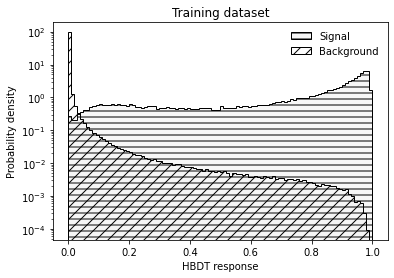

In [28]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Training dataset',
    common_selection=is_training,
    selection_1=is_signal,
    selection_2=is_bkg
)

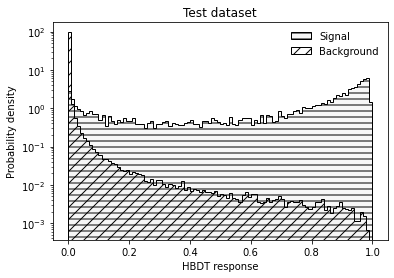

In [29]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Test dataset',
    common_selection=is_test,
    selection_1=is_signal,
    selection_2=is_bkg
)

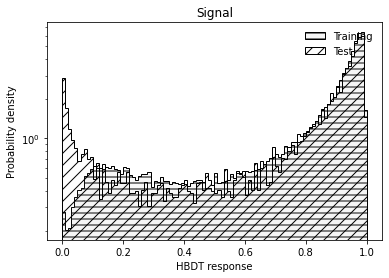

In [30]:
plot_compared_responses(
    label_1='Training',
    label_2='Test',
    title='Signal',
    common_selection=is_signal,
    selection_1=is_training,
    selection_2=is_test
)

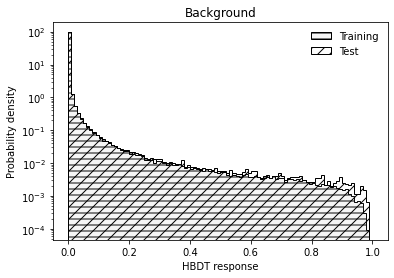

In [31]:
plot_compared_responses(
    label_1='Training',
    label_2='Test',
    title='Background',
    common_selection=is_bkg,
    selection_1=is_training,
    selection_2=is_test
)

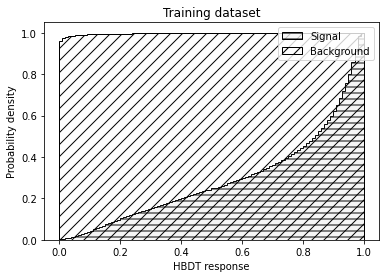

In [32]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Training dataset',
    common_selection=is_training,
    selection_1=is_signal,
    selection_2=is_bkg,
    cumulative=True,
    legend_frame=True
)

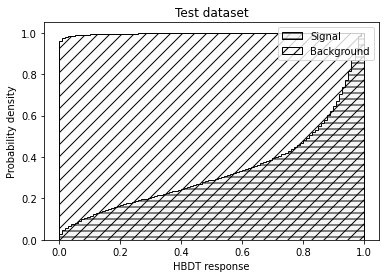

In [33]:
plot_compared_responses(
    label_1='Signal',
    label_2='Background',
    title='Test dataset',
    common_selection=is_test,
    selection_1=is_signal,
    selection_2=is_bkg,
    cumulative=True,
    legend_frame=True
)

## Kolmogorov-Smirnov test
### Signal (train vs. test)

In [34]:
stats.kstest(
    df_model_response.loc[is_training & is_signal, 'predicted'],
    df_model_response.loc[is_test & is_signal, 'predicted'],
)

KstestResult(statistic=0.07408358310043422, pvalue=3.9826122504904954e-35)

### Background (train vs. test)

In [35]:
stats.kstest(
    df_model_response.loc[is_training & is_bkg, 'predicted'],
    df_model_response.loc[is_test & is_bkg, 'predicted'],
)

KstestResult(statistic=0.001236296296296291, pvalue=0.38081033219358296)